In [ ]:
import torch
import torch.nn as nn
import gpytorch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pm4py
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

# Data Handling

#### Loading data

In [ ]:
log = pm4py.read_xes('./data/BPI Challenge 2017.xes/BPI Challenge 2017.xes', return_legacy_log_object=True)

c:\Users\Henri\OneDrive - Universität zu Köln\Dokumente\TUM\3. Semester\BPTM Seminar\.venv\Lib\site-packages\pm4py\utils.py:992: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")
c:\Users\Henri\OneDrive - Universität zu Köln\Dokumente\TUM\3. Semester\BPTM Seminar\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 31509/31509 [01:15<00:00, 418.25it/s]


In [ ]:
allowed_events = ["A_Pending", "A_Cancelled", "A_Denied"]

pruned_log = pm4py.filter_event_attribute_values(
    log,
    attribute_key="concept:name",
    values=allowed_events,
    level="case",
    retain=True
)

perc = 0.001
filtered_log = pm4py.filter_variants_by_coverage_percentage(pruned_log, perc)

In [ ]:
df = pm4py.convert_to_dataframe(filtered_log)

In [5]:
df.head()

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Sorting

In [6]:
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'])
df = df.sort_values(['case:concept:name', 'time:timestamp'])

--- Sequence Length Statistics ---
Min Length: 16
Mean Length: 24.23
Median: 24.0
90th Percentile: 31.0
95th Percentile: 35.0
99th Percentile: 39.0
Max Length: 40


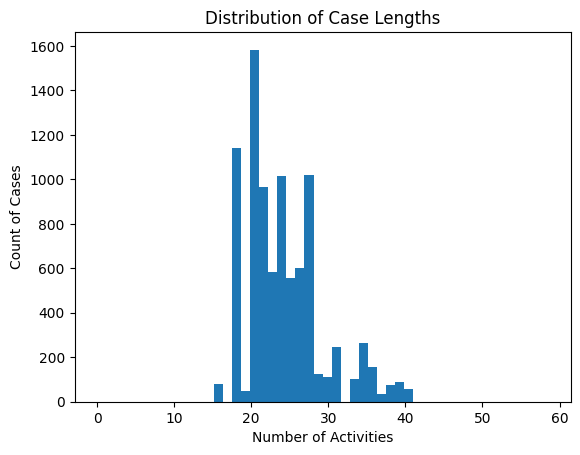

In [7]:
case_lengths = df.groupby('case:concept:name').size()

# 2. Print Statistics
print("--- Sequence Length Statistics ---")
print(f"Min Length: {case_lengths.min()}")
print(f"Mean Length: {case_lengths.mean():.2f}")
print(f"Median: {case_lengths.median()}")
print(f"90th Percentile: {np.percentile(case_lengths, 90)}")
print(f"95th Percentile: {np.percentile(case_lengths, 95)}")
print(f"99th Percentile: {np.percentile(case_lengths, 99)}")
print(f"Max Length: {case_lengths.max()}")

# 3. (Optional) Quick Histogram
# This helps you visually see the "long tail"
plt.hist(case_lengths, bins=50, range=(0, np.percentile(case_lengths, 99) * 1.5))
plt.title("Distribution of Case Lengths")
plt.xlabel("Number of Activities")
plt.ylabel("Count of Cases")
plt.show()

In [8]:
CUTOFF_LIMIT = 50 # Replace this with your chosen number

# 1. Identify valid case IDs
valid_cases = case_lengths[case_lengths <= CUTOFF_LIMIT].index

# 2. Filter the DataFrame
# This keeps only rows belonging to short/normal cases
df = df[df['case:concept:name'].isin(valid_cases)].copy()

#### Feature engineering

In [9]:
df['ActivityID'] = df['concept:name'].astype('category').cat.codes

In [10]:
# Group by Case to calculate time differences relative to THAT case
g = df.groupby('case:concept:name')

# A. Delta Time (Time since previous step)
# shift(1) gets the previous row's time. 
df['Prev_Time'] = g['time:timestamp'].shift(1)
df['Delta_Time'] = (df['time:timestamp'] - df['Prev_Time']).dt.total_seconds().fillna(0)

# B. Cumulative Time (Time since case start)
df['Case_Start_Time'] = g['time:timestamp'].transform('min')
df['Cumulative_Time'] = (df['time:timestamp'] - df['Case_Start_Time']).dt.total_seconds()



# C. Normalize/Log Transform (CRITICAL for Neural Networks)
# Raw seconds (e.g., 3600, 84000) are too large for LSTMs. Log squeezes them.
df['Log_Delta'] = np.log1p(df['Delta_Time'])
df['Log_Cumulative'] = np.log1p(df['Cumulative_Time'])
df['log_loan_amount'] = np.log1p(df['case:RequestedAmount'])

#### extract prefixes

In [11]:
# 1. GROUP BY CASE
# We extract the full sequences first
feature_cols = ['ActivityID', 'Log_Delta', 'Log_Cumulative', 'log_loan_amount']
grouped = df.groupby('case:concept:name')

X_samples = []
y_samples = []

print("Generating Prefixes...")

for case_id, group in grouped:
    # Convert group to numpy array
    # Shape: (Seq_Len, Features)
    case_data = group[feature_cols].values
    
    # We need the NEXT step's duration as the target
    # We use 'Log_Delta' as the target (Time since previous event)
    # The target for step t is the Delta_Time of step t+1
    next_step_durations = group['Log_Delta'].shift(-1).values
    
    # Iterate through the case to create prefixes
    # We stop at len-1 because the last event has no "next event"
    for i in range(len(case_data) - 1):
        # INPUT: History from start (0) up to current step (i)
        # Shape: (i+1, Features)
        prefix = case_data[0 : i+1]
        
        # TARGET: The duration of the NEXT event (i+1)
        target = next_step_durations[i]
        
        # Validation: skip if target is NaN (shouldn't happen with logic above)
        if not np.isnan(target):
            X_samples.append(torch.tensor(prefix, dtype=torch.float32))
            y_samples.append(target)

Generating Prefixes...


In [12]:
# 2. PAD SEQUENCES
# Now we have a list of many variable-length prefixes
X_tensor = pad_sequence(X_samples, batch_first=True, padding_value=0)
y_tensor = torch.tensor(y_samples, dtype=torch.float32)

print(f"Total Training Samples: {len(y_samples)}")
print(f"X Shape: {X_tensor.shape}")

Total Training Samples: 205871
X Shape: torch.Size([205871, 39, 4])


# Model Architecture

#### definition

In [13]:
# ---------------------------------------------------------
# 1. MODEL ARCHITECTURE
# ---------------------------------------------------------

class LSTMFeatureExtractor(nn.Module):
    """
    Extracts features from the sequence data.
    Input: (Batch, Seq_Len, Input_Dim) -> Output: (Batch, Feature_Dim)
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, mask=None):
        lstm_out, _ = self.lstm(x)
        
        if mask is None:
            # If no mask, take the last step
            features = lstm_out[:, -1, :]
        else:
            # If mask exists, take the last VALID step based on the mask
            # mask sum gives length; minus 1 gives index. Clamp to 0 to be safe.
            seq_lengths = mask.sum(dim=1).long() - 1
            seq_lengths = seq_lengths.clamp(min=0)
            
            # Select the correct hidden state for each batch element
            batch_indices = torch.arange(x.size(0), device=x.device)
            features = lstm_out[batch_indices, seq_lengths, :]
            
        return self.linear(features)

class GPLayer(gpytorch.models.ApproximateGP):
    """
    The Gaussian Process Layer.
    Input: (Batch, Feature_Dim) -> Output: MultivariateNormal
    """
    def __init__(self, inducing_points, feature_dim):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=inducing_points.size(0)
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=feature_dim)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class DKLModel(nn.Module):
    """
    The Deep Kernel Learning Wrapper.
    Combines LSTM and GP into one forward pass.
    """
    def __init__(self, feature_extractor, gp_layer):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.gp_layer = gp_layer
        
        # This scaler helps map LSTM outputs to the [-1, 1] range 
        # which stabilizes the GP training
        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

    def forward(self, x, mask):
        features = self.feature_extractor(x, mask)
        features = self.scale_to_bounds(features)
        res = self.gp_layer(features)
        return res

# ---------------------------------------------------------
# 2. DATA HANDLING
# ---------------------------------------------------------

class ProcessDataset(Dataset):
    def __init__(self, raw_sequences, targets):
        self.data = raw_sequences
        self.targets = targets
        self.max_len = max([s.size(0) for s in self.data])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = self.data[idx]
        target = self.targets[idx]
        
        # 1. Create Mask (1 for data, 0 for padding)
        mask = torch.ones(self.max_len)
        mask[seq.size(0):] = 0
        
        # 2. Pad Sequence
        pad_size = self.max_len - seq.size(0)
        if pad_size > 0:
            pad = torch.zeros(pad_size, seq.size(1))
            seq = torch.cat((seq, pad), dim=0)
            
        return seq, torch.tensor(target).float(), mask

#### training

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # Should print 'cuda'

Using device: cuda


In [16]:
from tqdm.auto import tqdm

# --- A. Data Setup ---
dataset = ProcessDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# --- Pre-Flight Dashboard ---
# Checks exactly how much work needs to be done before starting
total_samples = len(dataset)
batch_size = dataloader.batch_size
num_batches = len(dataloader)

print(f"\n--- Training Configuration ---")
print(f"Total Samples:      {total_samples}")
print(f"Batch Size:         {batch_size}")
print(f"Batches per Epoch:  {num_batches}")
print(f"Total Epochs:       30")
print(f"------------------------------\n")

# --- B. Initialize Model ---
lstm_hidden = 16
feature_dim = 2 
num_inducing = 20
input_dim = 4

extractor = LSTMFeatureExtractor(input_dim, lstm_hidden, feature_dim)
inducing_points = torch.randn(num_inducing, feature_dim)
gp_layer = GPLayer(inducing_points, feature_dim)

model = DKLModel(extractor, gp_layer)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# --- C. Setup Optimizer ---
optimizer = torch.optim.Adam([
    {'params': model.feature_extractor.parameters()},
    {'params': model.gp_layer.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

mll = gpytorch.mlls.VariationalELBO(likelihood, model.gp_layer, num_data=len(dataset))

# --- D. Training Loop ---
model.train()
likelihood.train()

# We use ONE progress bar for the Epochs because batches are too fast
# This bar will show: "Epoch 1/30 ... [ETA] ... loss=..."
epoch_pbar = tqdm(range(30), desc="Training Progress", unit="epoch")

for epoch in epoch_pbar:
    epoch_loss = 0
    batch_count = 0
    
    # Inner loop over batches (No progress bar here to avoid flickering)
    for batch_x, batch_y, batch_mask in dataloader:
        batch_count += 1 
        if batch_count % 1000 == 0:
            print(batch_count)
        optimizer.zero_grad()
        
        output = model(batch_x, mask=batch_mask)
        loss = -mll(output, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    # Calculate average loss for this epoch
    avg_loss = epoch_loss / num_batches
    
    # Update the progress bar text with the loss
    # This lets you see the loss dropping in real-time next to the bar
    epoch_pbar.set_postfix({'Avg Loss': f'{avg_loss:.4f}'})

print("Training Complete.")


--- Training Configuration ---
Total Samples:      205871
Batch Size:         32
Batches per Epoch:  6434
Total Epochs:       30
------------------------------



Training Progress:   0%|          | 0/30 [00:00<?, ?epoch/s]C:\Users\Henri\AppData\Local\Temp\ipykernel_29456\3695142226.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return seq, torch.tensor(target).float(), mask


1000


Training Progress:   0%|          | 0/30 [00:14<?, ?epoch/s]


KeyboardInterrupt: 

In [ ]:
# ---------------------------------------------------------
# 4. EVALUATION
# ---------------------------------------------------------

model.eval()
likelihood.eval()

print("\nEvaluation (First 3 samples):")
# Test on the first batch from the loader
test_x, test_y, test_mask = next(iter(dataloader))

with torch.no_grad():
    # Get distribution
    observed_pred = likelihood(model(test_x, mask=test_mask))
    
    # Extract Mean and Confidence
    pred_log_mean = observed_pred.mean
    pred_log_var = observed_pred.variance
    
    # Convert Log-Time back to Real-Time
    pred_time = torch.exp(pred_log_mean)
    real_time = torch.exp(test_y)
    
    # Calculate Uncertainty (2 standard deviations)
    # Note: Confidence intervals in log-space are asymmetric in real-space
    lower_conf = torch.exp(pred_log_mean - 2 * torch.sqrt(pred_log_var))
    upper_conf = torch.exp(pred_log_mean + 2 * torch.sqrt(pred_log_var))

# Print results
for i in range(3):
    print(f"Sample {i+1}:")
    print(f"  Actual Time:    {real_time[i].item():.2f}")
    print(f"  Predicted Time: {pred_time[i].item():.2f}")
    print(f"  95% Conf Range: {lower_conf[i].item():.2f} - {upper_conf[i].item():.2f}")
    print("-" * 30)